In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud

In [3]:
temp = pd.read_stata("../data/country_partner_sitcproductsection_year.dta")

In [4]:
len(set(list(temp["location_code"])))

249

In [5]:
temp

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,1,0,2018.0,46139.0,0.0,0.800212,0.174964,ABW,AFG,0
1,0,1,0,2019.0,62796.0,0.0,0.935727,-0.282090,ABW,AFG,0
2,2,1,0,2007.0,0.0,5560.0,-1.794320,-1.203246,AGO,AFG,0
3,2,1,0,2014.0,0.0,41341.0,-1.547068,-1.121438,AGO,AFG,0
4,2,1,0,2009.0,0.0,29262.0,-1.607222,-1.188794,AGO,AFG,0
...,...,...,...,...,...,...,...,...,...,...,...
7290683,192,235,4,1971.0,280361.0,350105.0,0.540057,0.916770,SGP,VDR,4
7290684,192,235,4,1972.0,144771.0,298686.0,0.461371,0.925253,SGP,VDR,4
7290685,192,235,4,1973.0,771424.0,537051.0,0.656068,1.318713,SGP,VDR,4
7290686,192,235,4,1974.0,1721284.0,638357.0,0.689488,1.429749,SGP,VDR,4


# Data Imports

##### Extract product codes

In [6]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

In [7]:
data_dict

,more,minimumInputLength,classCode,className,results
0,False,1,S2,SITC Rev. 2,"{'id': 'ALL', 'text': 'All SITC Rev.2 categori..."
1,False,1,S2,SITC Rev. 2,"{'id': 'TOTAL', 'text': 'Total of all SITC Rev..."
2,False,1,S2,SITC Rev. 2,"{'id': 'AG1', 'text': 'AG1 - All 1-digit SITC ..."
3,False,1,S2,SITC Rev. 2,"{'id': 'AG2', 'text': 'AG2 - All 2-digit SITC ..."
4,False,1,S2,SITC Rev. 2,"{'id': 'AG3', 'text': 'AG3 - All 3-digit SITC ..."
...,...,...,...,...,...
2579,False,1,S2,SITC Rev. 2,"{'id': '971', 'text': '971 - Gold, non-monetar..."
2580,False,1,S2,SITC Rev. 2,"{'id': '9710', 'text': '9710 - Gold, non-monet..."
2581,False,1,S2,SITC Rev. 2,"{'id': '97101', 'text': '97101 - Gold (includi..."
2582,False,1,S2,SITC Rev. 2,"{'id': '97102', 'text': '97102 - Rolled gold o..."


In [8]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append(item_def["text"].split(" - ", 1))
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])

In [9]:
product_codes

,code,product
0,AG1,All 1-digit SITC Rev.2 commodities
1,AG2,All 2-digit SITC Rev.2 commodities
2,AG3,All 3-digit SITC Rev.2 commodities
3,AG4,All 4-digit SITC Rev.2 commodities
4,AG5,All 5-digit SITC Rev.2 commodities
...,...,...
2577,971,"Gold, non-monetary (excluding gold ores and co..."
2578,9710,"Gold, non-monetary (excluding gold ores and co..."
2579,97101,"Gold (including platlnum-plated gold), non-mon..."
2580,97102,"Rolled gold on base metal or silver, unworked ..."


##### Extract Country Codes

In [10]:
country_codes = pd.read_excel("../data/ISO3166.xlsx")

In [11]:
country_codes

,English short name,French short name,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,Afghanistan (l'),AF,AFG,4
1,Albania,Albanie (l'),AL,ALB,8
2,Algeria,Algérie (l'),DZ,DZA,12
3,American Samoa,Samoa américaines (les),AS,ASM,16
4,Andorra,Andorre (l'),AD,AND,20
...,...,...,...,...,...
244,Western Sahara*,Sahara occidental (le)*,EH,ESH,732
245,Yemen,Yémen (le),YE,YEM,887
246,Zambia,Zambie (la),ZM,ZMB,894
247,Zimbabwe,Zimbabwe (le),ZW,ZWE,716


##### Extract Trade Data

In [12]:
#import trade data
n1962 = pd.read_stata("../data/country_partner_sitcproduct4digit_year_1962.dta")

In [13]:
#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
product_codes["sitc_product_code"] = product_codes["code"]

In [14]:
#join trade data and descriptions
n1962 = pd.merge(n1962, country_codes[["location_code", "country_i"]],on = ["location_code"])
n1962 = pd.merge(n1962, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
n1962 = pd.merge(n1962, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

In [15]:
#check that importer, exporter, product combinations are unqiue
#when we perform groupby we do not lose any rows
len(n1962.groupby(["location_code", "partner_code", "sitc_product_code"])["import_value"].sum().reset_index()) == len(n1962)

True

In [16]:
n1962.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product'],
      dtype='object')

In [17]:
#flip exports so that we have an import relationshipship, rather than import/export
n1962_imports1 = n1962[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
n1962_imports1 = n1962_imports1[n1962_imports1["import_value"] != 0]

In [18]:
n1962_imports2 = n1962[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
n1962_imports2["temp1"] = n1962_imports2['partner_code']
n1962_imports2["temp2"] = n1962_imports2['location_code']

n1962_imports2['location_code'] = n1962_imports2["temp1"]
n1962_imports2['partner_code'] = n1962_imports2["temp2"]
n1962_imports2["import_value"] = n1962_imports2["export_value"]
n1962_imports2 = n1962_imports2[n1962_imports2["import_value"] != 0]
n1962_imports2 = n1962_imports1[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]

In [19]:
n1962 = pd.concat([n1962_imports1, n1962_imports2], ignore_index=True)

In [20]:
n1962

,location_id,partner_id,product_id,year,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_i,country_j,product
0,1,18,815,1962.0,3106,-0.629827,-0.654635,AFG,BEL,2690,Afghanistan,Belgium,Old clothing and other old textile articles; rags
1,2,18,815,1962.0,137159,-0.725610,-0.703291,AGO,BEL,2690,Angola,Belgium,Old clothing and other old textile articles; rags
2,15,18,815,1962.0,10884,2.045399,2.510271,AUT,BEL,2690,Austria,Belgium,Old clothing and other old textile articles; rags
3,17,18,815,1962.0,158766,-1.461755,-0.558035,BDI,BEL,2690,Burundi,Belgium,Old clothing and other old textile articles; rags
4,23,18,815,1962.0,236160,0.395243,0.097470,BGR,BEL,2690,Bulgaria,Belgium,Old clothing and other old textile articles; rags
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175689,31,8,733,1962.0,3600,-0.136485,-0.461491,BOL,ARG,0742,Bolivia (Plurinational State of),Argentina,Maté
1175690,64,180,733,1962.0,5467,1.690508,2.832390,DNK,PRY,0742,Denmark,Paraguay,Maté
1175691,8,180,733,1962.0,1011522,-0.275650,-0.526755,ARG,PRY,0742,Argentina,Paraguay,Maté
1175692,230,180,733,1962.0,78140,0.106032,-0.316739,URY,PRY,0742,Uruguay,Paraguay,Maté


# Calculate a network for a given year

### Calculate RCA

In [21]:
#total world exports 
world_exports = n1962.groupby(["sitc_product_code"])["import_value"].sum().reset_index()
world_exports["total_product_world"] = world_exports["import_value"]
world_exports["total_world"] = sum(world_exports["import_value"])
world_exports["avg_frac"] = world_exports["total_product_world"]*1000/world_exports["total_world"]

In [22]:
#total_country exports
country_exports = n1962.groupby(["partner_code","sitc_product_code", "country_j", "product"])["import_value"].sum().reset_index()
country_exports["total_product_country"] = country_exports["import_value"]
country_totals = country_exports.groupby(["partner_code"])["import_value"].sum().reset_index()
country_totals["total_country"] = country_totals["import_value"]
country_exports = pd.merge(country_exports, 
                           country_totals[["partner_code", "total_country"]], on = ["partner_code"])
country_exports["country_frac"] = country_exports["total_product_country"]*1000/country_exports["total_country"]

In [23]:
country_exports

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac
0,AFG,0230,Afghanistan,Butter,7142,7142,158227374,0.045138
1,AFG,0251,Afghanistan,....in shell,21698,21698,158227374,0.137132
2,AFG,0252,Afghanistan,....not in shell,21698,21698,158227374,0.137132
3,AFG,0545,Afghanistan,Other fresh or chilled vegetables,143598,143598,158227374,0.907542
4,AFG,0548,Afghanistan,"Vegetable products, roots and tubers, chiefly ...",318800,318800,158227374,2.014822
...,...,...,...,...,...,...,...,...
42909,ZAF,9110,South Africa,Postal packages not classified according to kind,2225774,2225774,2050023186,1.085731
42910,ZAF,9310,South Africa,"Special transactions, commodity not classified...",4341826,4341826,2050023186,2.117940
42911,ZAF,9410,South Africa,"Animals, live, n.e.s., (including zoo animals,...",114292,114292,2050023186,0.055752
42912,ZAF,9510,South Africa,"Armoured fighting vehicles, war firearms, ammu...",17804,17804,2050023186,0.008685


In [24]:
country_exports = pd.merge(country_exports, world_exports[["sitc_product_code", "avg_frac"]],
                          on = ["sitc_product_code"])
country_exports["RCA"] = country_exports["country_frac"]/ country_exports["avg_frac"]

In [25]:
country_exports.sort_values(by = ["RCA"])

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac,avg_frac,RCA
11419,CHE,3330,Switzerland,Crude petroleum and oils obtained from bitumin...,2168,2168,4137678006,0.000524,26.241352,0.000020
21029,VEN,7841,Venezuela (Bolivarian Republic of),"Chassis fitted with engines, for the motor veh...",276,276,1808026910,0.000153,5.760565,0.000026
21123,VEN,7842,Venezuela (Bolivarian Republic of),"Bodies (including cabs), for the motor vehicle...",276,276,1808026910,0.000153,5.760565,0.000026
21217,VEN,7849,Venezuela (Bolivarian Republic of),"Other parts and accessories, n.e.s. of the mot...",276,276,1808026910,0.000153,4.331211,0.000035
11443,NOR,3330,Norway,Crude petroleum and oils obtained from bitumin...,2244,2244,1832321006,0.001225,26.241352,0.000047
...,...,...,...,...,...,...,...,...,...,...
9910,NPL,2460,Nepal,Pulpwood (including chips and wood waste),269170,269170,269170,1000.000000,1.243135,804.417711
23608,SOM,0012,Somalia,"Sheep and goats, live",14051858,14051858,53437442,262.959032,0.320092,821.511581
2634,MNG,2683,Mongolia,"Fine animal hair, not carded or combed",8587388,8587388,9095486,944.137345,0.771663,1223.509727
25411,BDI,2876,Burundi,Tin ores and concentrates,6236934,6236934,8055432,774.251958,0.556668,1390.869103


In [26]:
RCA = country_exports[country_exports["RCA"] > 1]

In [27]:
RCA["i"] = RCA["partner_code"]
RCA["country_i"] = RCA["country_j"]
RCA["k"] = RCA["sitc_product_code"]

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/1275121748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RCA["i"] = RCA["partner_code"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/1275121748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RCA["country_i"] = RCA["country_j"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/1275121748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [28]:
product_total_RCA = RCA.groupby(["sitc_product_code", "product"])["partner_code"].count().reset_index()
product_total_RCA["total_comp_advantage"] = product_total_RCA["partner_code"]
product_total_RCA["k"] = product_total_RCA["sitc_product_code"]
product_total_RCA["k_2"] = product_total_RCA["k"]

In [29]:
product_total_RCA

,sitc_product_code,product,partner_code,total_comp_advantage,k,k_2
0,0011,Animals of the bovine species (including buffa...,25,25,0011,0011
1,0012,"Sheep and goats, live",19,19,0012,0012
2,0013,"Swine, live",16,16,0013,0013
3,0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",11,11,0014,0014
4,0015,"Horses, asses, mules and hinnies, live",14,14,0015,0015
...,...,...,...,...,...,...
775,9110,Postal packages not classified according to kind,13,13,9110,9110
776,9310,"Special transactions, commodity not classified...",25,25,9310,9310
777,9410,"Animals, live, n.e.s., (including zoo animals,...",32,32,9410,9410
778,9510,"Armoured fighting vehicles, war firearms, ammu...",7,7,9510,9510


In [30]:
nodes = len(set(product_total_RCA["k"]))
nodes*(nodes-1)/2

303810.0

In [31]:
%%time
conditional_RCA = pd.merge(RCA[["i", "k", "country_i", "product", "RCA"]],
                          RCA[["i", "k", "product", "RCA"]],
                          on = ["i"], 
                          suffixes = ("", "_2"))
conditional_RCA = conditional_RCA[conditional_RCA["k"] != conditional_RCA["k_2"]]

CPU times: user 296 ms, sys: 66.8 ms, total: 363 ms
Wall time: 380 ms


In [32]:
%%time
conditional_RCA = conditional_RCA.groupby(["k", "product", "k_2", "product_2"])["i"].count().reset_index()

CPU times: user 766 ms, sys: 16.8 ms, total: 783 ms
Wall time: 794 ms


In [33]:
conditional_RCA 

,k,product,k_2,product_2,i
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10
1,0011,Animals of the bovine species (including buffa...,0013,"Swine, live",6
2,0011,Animals of the bovine species (including buffa...,0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",4
3,0011,Animals of the bovine species (including buffa...,0015,"Horses, asses, mules and hinnies, live",7
4,0011,Animals of the bovine species (including buffa...,0019,Live animals of a kind mainly used for human f...,10
...,...,...,...,...,...
521887,9610,"Coin (other than gold coin), not being legal t...",8999,"Manufactured goods, n.e.s.",2
521888,9610,"Coin (other than gold coin), not being legal t...",9110,Postal packages not classified according to kind,5
521889,9610,"Coin (other than gold coin), not being legal t...",9310,"Special transactions, commodity not classified...",6
521890,9610,"Coin (other than gold coin), not being legal t...",9410,"Animals, live, n.e.s., (including zoo animals,...",9


In [34]:
%%time
#eliminate flipped pairs
filter_df = pd.DataFrame(np.sort(conditional_RCA[["k", "k_2"]].values, axis=1), 
                         index=conditional_RCA[["k", "k_2"]].index, 
                         columns=conditional_RCA[["k", "k_2"]].columns).drop_duplicates() #eliminate flipped pairs

CPU times: user 156 ms, sys: 8.77 ms, total: 165 ms
Wall time: 168 ms


In [35]:
#perform filtering
conditional_RCA = pd.merge(conditional_RCA, filter_df,
                          on = ["k", "k_2"],
                          how = "inner")

In [36]:
conditional_RCA = pd.merge(conditional_RCA, product_total_RCA[["k", "total_comp_advantage"]], on = "k")
conditional_RCA = pd.merge(conditional_RCA, product_total_RCA[["k_2", "total_comp_advantage"]], 
                           on = "k_2", suffixes = ("", "_2"))

In [37]:
conditional_RCA

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10,25,19
1,0011,Animals of the bovine species (including buffa...,0013,"Swine, live",6,25,16
2,0012,"Sheep and goats, live",0013,"Swine, live",3,19,16
3,0011,Animals of the bovine species (including buffa...,0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",4,25,11
4,0012,"Sheep and goats, live",0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",2,19,11
...,...,...,...,...,...,...,...
260941,2239,Flour or meals of oil seeds or oleaginous frui...,2712,"Sodium nitrate, natural, containing not more t...",1,18,1
260942,2483,"Wood of non-coniferous species, sawn, planed, ...",2712,"Sodium nitrate, natural, containing not more t...",1,41,1
260943,2512,Mechanical wood pulp,2712,"Sodium nitrate, natural, containing not more t...",1,5,1
260944,2518,"Chemical wood pulp, sulphite",2712,"Sodium nitrate, natural, containing not more t...",1,9,1


In [38]:
conditional_RCA["conditional_prob1"] = conditional_RCA["i"]/conditional_RCA["total_comp_advantage"]
conditional_RCA["conditional_prob2"] = conditional_RCA["i"]/conditional_RCA["total_comp_advantage_2"]

In [39]:
conditional_RCA["prob"] = conditional_RCA[["conditional_prob1", "conditional_prob2"]].min(axis = 1)

In [40]:
conditional_RCA.sort_values(by = ["prob"])

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob
242523,2924,Plants and parts (including seeds and fruit) o...,7783,Electrical equipment for internal combustion e...,1,53,8,0.018868,0.125000,0.018868
191908,2924,Plants and parts (including seeds and fruit) o...,8935,"Articles of electric lighting, of the material...",1,53,11,0.018868,0.090909,0.018868
79400,2924,Plants and parts (including seeds and fruit) o...,6732,"Bars and rods (excluding wire rod), of iron or...",1,53,7,0.018868,0.142857,0.018868
108226,2924,Plants and parts (including seeds and fruit) o...,7361,Metal cutting machine-tools,1,53,6,0.018868,0.166667,0.018868
134452,2924,Plants and parts (including seeds and fruit) o...,7741,Electro-medical apparatus (other than radlolog...,1,53,10,0.018868,0.100000,0.018868
...,...,...,...,...,...,...,...,...,...,...
235736,7264,Printing presses,7268,Bookbinding machinery (including book sewing m...,6,6,6,1.000000,1.000000,1.000000
235735,7263,"Machinery, apparatus and accessories for type-...",7268,Bookbinding machinery (including book sewing m...,6,6,6,1.000000,1.000000,1.000000
200684,8973,"Jewellery of gold, silver or platinum group me...",8974,Other articles of precious metal or rolled pre...,9,9,9,1.000000,1.000000,1.000000
52114,6514,Yarn containing 85% or more by weight of synth...,6516,"Yarn of discontinuous synthetic fibres, contai...",10,10,10,1.000000,1.000000,1.000000


In [41]:
#fraction of non-existent edges: 
edges = nodes*(nodes-1)/2
1 - len(conditional_RCA)/edges

0.1410881801125704

In [42]:
len(conditional_RCA[conditional_RCA["prob"] < 0.1])/edges

0.18490503933379415

In [43]:
len(conditional_RCA[conditional_RCA["prob"] < 0.2])/edges

0.4284092031203713

### Transform RCA into matrix with edges 

### Look at MST
References:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.minimum_spanning_tree.html
- https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.to_scipy_sparse_matrix.html#networkx.convert_matrix.to_scipy_sparse_matrix

In [44]:
%%time
conditional_RCA["weight"] = conditional_RCA["prob"]*-100
G=nx.from_pandas_edgelist(conditional_RCA, "k", "k_2", ["weight"])

CPU times: user 404 ms, sys: 19.4 ms, total: 424 ms
Wall time: 425 ms


In [45]:
A = nx.to_scipy_sparse_matrix(G)

In [46]:
A.toarray().astype(np.float64)

array([[  0.        , -40.        , -24.        , ..., -31.25      ,
         -4.        ,  -8.        ],
       [-40.        ,   0.        , -15.78947368, ..., -28.125     ,
         -5.26315789, -15.78947368],
       [-24.        , -15.78947368,   0.        , ..., -18.75      ,
        -18.75      ,   0.        ],
       ...,
       [-31.25      , -28.125     , -18.75      , ...,   0.        ,
         -3.125     , -28.125     ],
       [ -4.        ,  -5.26315789, -18.75      , ...,  -3.125     ,
          0.        ,  -5.88235294],
       [ -8.        , -15.78947368,   0.        , ..., -28.125     ,
         -5.88235294,   0.        ]])

In [47]:
MST = minimum_spanning_tree(A)

In [48]:
MST.toarray()

array([[  0., -40.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [49]:
MST_matrix = MST.toarray().astype(np.float64)

In [50]:
check = list(MST_matrix[2])
set(check)

{-57.89473684210527, -50.0, 0.0}

In [51]:
def connected_nodes(MST_matrix, index):
    check = list(MST_matrix[index])
    
    connections = list(set(check))
    
    connected_list = []
    connected_list.append(list(G.nodes())[index])
    
    for value in connections:
        if value != 0:
            temp = check.index(value)
            connected_list.append(list(G.nodes())[temp])
    
    return(connected_list)

In [52]:
check_list = connected_nodes(MST_matrix, 6)

product_codes[product_codes["code"].isin(check_list)]

,code,product,sitc_product_code
41,0111,"Meat of bovine animals, fresh, chilled or froz...",0111
55,0149,Other prepared or preserved meat or meat offals,0149
206,0616,Natural honey,0616


In [53]:
check_list = connected_nodes(MST_matrix, 11)

product_codes[product_codes["code"].isin(check_list)]

,code,product,sitc_product_code
46,0116,Edible offal of the animals falling in heading...,0116
62,0224,"Milk and cream, preserved, concentrated or swe...",0224
1031,5921,"Starches, insulin and wheat gluten",5921


In [54]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [55]:
%%time
#create new adjacency matrix from MST 

mst_adjacency = []

for index in range(0, len(MST_matrix)):
    
    print('[%d]\r'%index, end="")
    
    prod1 = list(G.nodes())[index]
    
    check = list(MST_matrix[index])
    
    MST_connections = list(set(check))
    
    for value in MST_connections:
        if value != 0:
            temp = list_duplicates_of(check, value)
            
            for i in temp:
            
                prod2 = list(G.nodes())[i]
    
                temp_df = conditional_RCA[conditional_RCA["k"].isin([prod1,prod2]) & conditional_RCA["k_2"].isin([prod1,prod2])]
        
                mst_adjacency.append(temp_df)

CPU times: user 9.42 s, sys: 32.7 ms, total: 9.46 s
Wall time: 9.55 s


In [56]:
mst_data = pd.concat(mst_adjacency)

In [57]:
mst_data.head(5)

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
14,0011,Animals of the bovine species (including buffa...,0111,"Meat of bovine animals, fresh, chilled or froz...",12,25,20,0.48,0.600000,0.480000,-48.000000
2270,0011,Animals of the bovine species (including buffa...,0612,Refined sugar and other products of refining b...,13,25,30,0.52,0.433333,0.433333,-43.333333
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10,25,19,0.40,0.526316,0.400000,-40.000000
87,0011,Animals of the bovine species (including buffa...,0129,"Meat and edible meat offals, n.e.s., salted, i...",10,25,19,0.40,0.526316,0.400000,-40.000000
115,0013,"Swine, live",0142,"Sausages and the like, of meat, meat offal or ...",8,16,16,0.50,0.500000,0.500000,-50.000000


In [61]:
import spacy

nlp = spacy.load('en_core_web_sm') 
include_tags = {"NOUN"}

def clean_text(sentence):
    new_sentence = []
    
    if(len(sentence.split()) > 3): 
        for token in nlp(sentence.lower()):
            if token.pos_ in include_tags:
                new_sentence.append(token.text)
        new_text = " ".join(sorted(set(new_sentence[:min(len(new_sentence),3)]), 
                                   key = new_sentence[:min(len(new_sentence),3)].index ))
    else: new_text = sentence.lower()
        
    return(new_text)
    

In [62]:
mst_data["product"] = mst_data["product"].apply(lambda x: clean_text(x))
mst_data["product_2"] = mst_data["product_2"].apply(lambda x: clean_text(x))

In [63]:
mst_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
14,0011,animals species buffaloes,0111,meat animals,12,25,20,0.48,0.600000,0.480000,-48.000000
2270,0011,animals species buffaloes,0612,sugar products refining,13,25,30,0.52,0.433333,0.433333,-43.333333
0,0011,animals species buffaloes,0012,sheep goats,10,25,19,0.40,0.526316,0.400000,-40.000000
87,0011,animals species buffaloes,0129,meat offals,10,25,19,0.40,0.526316,0.400000,-40.000000
115,0013,"swine, live",0142,sausages meat,8,16,16,0.50,0.500000,0.500000,-50.000000
...,...,...,...,...,...,...,...,...,...,...,...
191743,8931,articles conveyance packing,8933,artleles objects persons,11,11,11,1.00,1.000000,1.000000,-100.000000
192443,8931,articles conveyance packing,8935,articles lighting materials,11,11,11,1.00,1.000000,1.000000,-100.000000
193144,8931,articles conveyance packing,8939,articles materials division,11,11,11,1.00,1.000000,1.000000,-100.000000
205574,8972,imitation jewellery,8994,umbrellas parasols walking,6,8,9,0.75,0.666667,0.666667,-66.666667


# Gephi Export of Full Graph

In [64]:
appended_data = mst_data.copy()
appended_data["weight"] = appended_data["weight"]*-1

In [66]:
#reformat data for GEPHI Export
node_df = appended_data[["k", "product"]]

temp = appended_data[["k_2", "product_2"]]
temp["k"] = appended_data["k_2"]
temp["product"] = appended_data["product_2"]

node_df = pd.concat([node_df, temp[["k","product"]]])
node_df = node_df.drop_duplicates()

edges_df = appended_data[["k", "k_2", "weight"]]
node_df["Id"] = node_df["k"]
node_df["Label"] = node_df["product"]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property1"] = "mst"
edges_df["property"] = 5

node_df = node_df.drop(columns = ["k", "product"])
edges_df = edges_df.drop(columns = ["k", "k_2"])

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/267850671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["k"] = appended_data["k_2"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/267850671.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["product"] = appended_data["product_2"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/267850671.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [67]:
node_df.to_csv("nodes_mst.csv", index = False)
edges_df.to_csv("edges_mst.csv", index = False)

In [ ]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.8].copy()

edges_df = additional_edges[["k", "k_2", "weight"]]
edges_df["weight"] = edges_df["weight"]*-1
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property"] = 1
edges_df["property1"] = 'appended'
edges_df = edges_df.drop(columns = ["k", "k_2"])

/tmp/ipykernel_192495/1719768201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["weight"] = edges_df["weight"]*-1
/tmp/ipykernel_192495/1719768201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["source"] = edges_df["k"]
/tmp/ipykernel_192495/1719768201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [69]:
edges_df.to_csv("edges_additional.csv", index = False)

## Gephi Export for Specific Countries

In [70]:
country = "TCD"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "HTI"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

In [71]:
node_df.to_csv("nodes_country.csv", index = False)

In [72]:
country_list = ["HTI", "NGA", "SDN", "CHN", "JPN", "KOR", "BHS"]

In [73]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.4].copy()

edges_df = additional_edges[["k", "k_2", "weight"]]
edges_df["weight"] = edges_df["weight"]*-1

country = country_list[6]
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df = edges_df[edges_df[country]]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property"] = 1
edges_df["property1"] = country
edges_df = edges_df.drop(columns = ["k", "k_2", country])
edges_df.to_csv("edges_" + country + ".csv", index = False)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/2502243478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["weight"] = edges_df["weight"]*-1
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/2502243478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)


In [74]:
edges_df

,weight,source,target,property,property1
12922,44.444444,0545,2783,1,BHS
15768,100.000000,2881,2882,1,BHS
16053,40.816327,2119,2911,1,BHS
16166,42.500000,0360,2919,1,BHS
16872,49.056604,2911,2924,1,BHS
21982,90.909091,4239,4249,1,BHS
35205,46.666667,2460,5851,1,BHS
35504,46.666667,2460,5852,1,BHS
35685,100.000000,5851,5852,1,BHS
37839,41.666667,5163,5989,1,BHS


In [76]:
country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["source"].isin(specialty) & edges_df["target"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

In [77]:
appended_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
14,0011,animals species buffaloes,0111,meat animals,12,25,20,0.48,0.600000,0.480000,48.000000
2270,0011,animals species buffaloes,0612,sugar products refining,13,25,30,0.52,0.433333,0.433333,43.333333
0,0011,animals species buffaloes,0012,sheep goats,10,25,19,0.40,0.526316,0.400000,40.000000
87,0011,animals species buffaloes,0129,meat offals,10,25,19,0.40,0.526316,0.400000,40.000000
115,0013,"swine, live",0142,sausages meat,8,16,16,0.50,0.500000,0.500000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...
191743,8931,articles conveyance packing,8933,artleles objects persons,11,11,11,1.00,1.000000,1.000000,100.000000
192443,8931,articles conveyance packing,8935,articles lighting materials,11,11,11,1.00,1.000000,1.000000,100.000000
193144,8931,articles conveyance packing,8939,articles materials division,11,11,11,1.00,1.000000,1.000000,100.000000
205574,8972,imitation jewellery,8994,umbrellas parasols walking,6,8,9,0.75,0.666667,0.666667,66.666667


In [78]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.4]

In [80]:
appended_data = pd.concat([appended_data, additional_edges])

In [81]:
appended_data = appended_data.drop_duplicates()

In [82]:
len(appended_data)

30176

In [83]:
edges

303810.0

# Look at MST-based graph

In [84]:
appended_data["weight"] = appended_data["prob"]*100
G=nx.from_pandas_edgelist(appended_data, "product", "product_2", ["weight"])

In [85]:
appended_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
14,0011,animals species buffaloes,0111,meat animals,12,25,20,0.480000,0.600000,0.480000,48.000000
2270,0011,animals species buffaloes,0612,sugar products refining,13,25,30,0.520000,0.433333,0.433333,43.333333
0,0011,animals species buffaloes,0012,sheep goats,10,25,19,0.400000,0.526316,0.400000,40.000000
87,0011,animals species buffaloes,0129,meat offals,10,25,19,0.400000,0.526316,0.400000,40.000000
115,0013,"swine, live",0142,sausages meat,8,16,16,0.500000,0.500000,0.500000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...
260333,7751,"Househo1d type laundry equipment, n.e.s. wheth...",7849,"Other parts and accessories, n.e.s. of the mot...",3,6,4,0.500000,0.750000,0.500000,50.000000
260347,7784,"Tools for working in the hand, with self-conta...",7849,"Other parts and accessories, n.e.s. of the mot...",3,5,4,0.600000,0.750000,0.600000,60.000000
260352,7831,Public-service type passenger motor vehicles (...,7849,"Other parts and accessories, n.e.s. of the mot...",3,7,4,0.428571,0.750000,0.428571,42.857143
260354,7841,"Chassis fitted with engines, for the motor veh...",7849,"Other parts and accessories, n.e.s. of the mot...",4,4,4,1.000000,1.000000,1.000000,100.000000


##### Export for Gephi

In [100]:
wb_indicators = pd.read_pickle("../data/all_wb_indicators.pickle")

In [140]:
gdp = wb_indicators['NY.GDP.MKTP.KD.ZG']
gdp = gdp.rename(columns={"economy": "Country Code"})

In [141]:
gdp

,Country Code,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,...,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.035375,6.429817,-0.020479,3.543630,2.116716,5.482371,5.257856,0.635029,-18.589100,17.172509
1,AFE,NaN,0.237304,7.984460,5.163873,4.583677,5.328044,3.913909,5.255309,4.026302,...,0.770097,4.229408,4.039082,2.895728,2.485952,2.639537,2.610797,2.038299,-3.042653,4.402447
2,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.752287,5.600745,2.724543,1.451315,2.260314,2.647003,1.189228,3.911603,-2.351101,-20.737146
3,AFW,NaN,1.835056,3.772898,7.282985,5.392705,4.056588,-1.807283,-9.595925,1.445941,...,5.135584,6.108758,5.930450,2.745137,0.113687,2.305623,2.946175,3.190879,-0.900382,3.965399
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.540000,4.950000,4.820000,0.940000,-2.580000,-0.150000,-1.316312,-0.700000,-5.600000,1.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.712195,5.340908,3.348804,5.916270,5.571757,4.825690,3.406631,4.756831,-5.340275,10.745612
262,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.392990,4.823519,-0.188690,-27.994546,-9.375124,-5.071796,0.752448,NaN,NaN,NaN
263,ZAF,NaN,3.844734,6.177931,7.373709,7.939609,6.122798,4.438386,7.196523,4.153373,...,2.396232,2.485468,1.413826,1.321862,0.664552,1.157947,1.522329,0.303453,-6.342471,4.913097
264,ZMB,NaN,1.361382,-2.490839,3.272393,12.214048,16.647456,-5.570310,7.919697,1.248330,...,7.597593,5.057232,4.697992,2.920375,3.776679,3.504336,4.034494,1.441306,-2.785055,4.598734


In [142]:
gdp = gdp[["Country Code", 'YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967']]

In [143]:
gdp["average"] = gdp[['YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967']].mean(axis = 1)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/1534773692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp["average"] = gdp[['YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967']].mean(axis = 1)


In [144]:
gdp.sort_values(by = 'average', ascending = False).head(10)

,Country Code,YR1963,YR1964,YR1965,YR1966,YR1967,average
182,OMN,NaN,NaN,NaN,5.204464,66.219084,35.711774
220,SUR,5.600000,6.500000,12.000000,19.200000,12.100000,11.080000
112,IRN,7.042075,8.475228,17.035712,11.502407,11.252803,11.061645
60,DZA,34.313729,5.839413,6.206898,-4.804971,9.452963,10.201606
40,CHN,10.300000,18.180000,16.950000,10.650000,-5.770000,10.062000
148,MAR,NaN,NaN,NaN,NaN,10.028841,10.028841
23,BHS,10.524055,10.501567,10.425596,9.071929,9.598114,10.024252
232,TGO,4.999694,14.286011,15.459713,9.408719,5.500372,9.930902
119,JPN,8.473642,11.676708,5.819708,10.638562,11.082142,9.538152
126,KOR,9.020568,9.473825,7.318434,11.993957,9.079607,9.377278


In [145]:
gdp.sort_values(by = 'average').head(10)

,Country Code,YR1963,YR1964,YR1965,YR1966,YR1967,average
253,VCT,-6.265339,3.669726,0.884935,0.000000,-9.523813,-2.246898
229,TCD,-1.599454,-2.510940,0.606228,-1.807092,0.767201,-0.908811
100,HTI,-1.892793,-1.647357,2.161798,-0.575787,-2.117686,-0.814365
174,NGA,8.578619,4.950489,4.884977,-4.250514,-15.743628,-0.316012
203,RWA,-9.820444,-12.464993,7.009529,7.008911,6.916018,-0.270196
86,GMB,NaN,NaN,NaN,NaN,0.000000,0.000000
206,SDN,-2.846972,-1.120449,6.777074,-3.575147,1.424081,0.131717
42,CMR,3.742550,3.547160,2.026054,4.614956,-10.912066,0.603731
250,URY,0.170459,2.440521,1.045604,3.062856,-3.656834,0.612521
227,SYR,-8.652747,9.271364,2.299374,-7.659066,8.257683,0.703322


In [146]:
country_exports[(country_exports.partner_code == "BHS") & (country_exports.RCA >1)]

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac,avg_frac,RCA
157,BHS,0545,Bahamas (the),Other fresh or chilled vegetables,2158810,2158810,22064588,97.840485,3.198981,30.584887
1564,BHS,2119,Bahamas (the),"Hides and skins, n.e.s.; waste and used leather",9884,9884,22064588,0.447958,0.386631,1.158618
2731,BHS,2919,Bahamas (the),"Other materials of animal origin, n.e.s.",58860,58860,22064588,2.667623,1.114035,2.394559
2947,BHS,2924,Bahamas (the),Plants and parts (including seeds and fruit) o...,43306,43306,22064588,1.962692,0.593590,3.306478
3355,BHS,5989,Bahamas (the),"Chemical products and preparations, n.e.s.",179022,179022,22064588,8.113544,2.539248,3.195254
4555,BHS,7131,Bahamas (the),"Internal combustion piston engines, for aircra...",75636,75636,22064588,3.427936,0.872901,3.927060
4648,BHS,7144,Bahamas (the),Reaction engines,75636,75636,22064588,3.427936,0.872901,3.927060
4741,BHS,7148,Bahamas (the),"Gas turbines, n.e.s.",80652,80652,22064588,3.655269,0.918809,3.978268
4834,BHS,7149,Bahamas (the),"Parts, n.e.s. of the engines and motors of gro...",80652,80652,22064588,3.655269,1.293751,2.825327
4927,BHS,7188,Bahamas (the),"Engines and motors, n.e.s. (wind engines, hot ...",75636,75636,22064588,3.427936,1.247843,2.747090


In [147]:
node_df = appended_data[["k", "product"]]

temp = appended_data[["k_2", "product_2"]]
temp["k"] = appended_data["k_2"]
temp["product"] = appended_data["product_2"]

node_df = pd.concat([node_df, temp[["k", "product"]]])
node_df = node_df.drop_duplicates()

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/2561320633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["k"] = appended_data["k_2"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/2561320633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["product"] = appended_data["product_2"]


In [148]:
node_df

,k,product
14,0011,animals species buffaloes
115,0013,"swine, live"
196572,0014,poultry fowls ducks
1231,0015,horses asses mules
209936,0019,animals kind food
...,...,...
209936,9410,"Animals, live, n.e.s., (including zoo animals,..."
210697,9510,"Armoured fighting vehicles, war firearms, ammu..."
214017,6330,Cork manufactures
223469,6672,Diamonds (other than sorted industrial diamond...


In [149]:
edges_df = appended_data[["k", "k_2", "weight"]]
node_df["Id"] = node_df["k"]
node_df["Label"] = node_df["product"]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/3597028186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["source"] = edges_df["k"]
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/3597028186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["target"] = edges_df["k_2"]


In [150]:
country = "TCD"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "HTI"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/3974568580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/3974568580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_75763/3974568580.py:14: SettingWithCopyWarn

In [151]:
node_df = node_df.drop(columns = ["k", "product"])

In [152]:
edges_df = edges_df.drop(columns = ["k", "k_2"])

In [153]:
node_df.to_csv("nodes.csv", index = False)
edges_df.to_csv("edges.csv", index = False)

In [154]:
partition = community_louvain.best_partition(G, randomize = True)

In [155]:
partition

{'animals species buffaloes': 9,
 'meat animals': 9,
 'sugar products refining': 1,
 'sheep goats': 9,
 'meat offals': 9,
 'swine, live': 2,
 'sausages meat': 2,
 'vegetables preservative': 2,
 'poultry fowls ducks': 2,
 'pens pencils fountain': 9,
 'cereal meals flours': 2,
 'horses asses mules': 2,
 'animals kind food': 1,
 'animals zoo': 1,
 'salt rock': 1,
 'natural honey': 9,
 'meat sheep goats': 9,
 'animals oils fats': 9,
 'meat': 2,
 'meat horses asses': 2,
 'plates iron steel': 1,
 '....in shell': 7,
 'meat swine': 2,
 'wood species sawn': 2,
 'plasters limestone flux': 2,
 'offal animals headings': 2,
 'acyclic hydrocarbons': 2,
 'soya bean oil': 2,
 'sunflower seed oil': 2,
 'milk cream': 9,
 'flour': 2,
 'starches insulin wheat': 2,
 'meat offal': 2,
 'products preparations': 2,
 'vegetable oils': 9,
 'meat extracts': 2,
 'fish caviar substitutes': 2,
 'tugs purpose vessels': 2,
 'butter': 9,
 'chocolate food preparations': 9,
 'cigars, cheroots; cigarillos': 9,
 'tubers rh

In [156]:
inv_partition = {}
for k, v in partition.items():
    inv_partition[v] = inv_partition.get(v, []) + [k]

In [157]:
inv_partition.keys()

dict_keys([9, 1, 2, 7, 10, 11, 12, 13, 14, 15, 16, 17, 0, 3, 4, 5, 6, 8])

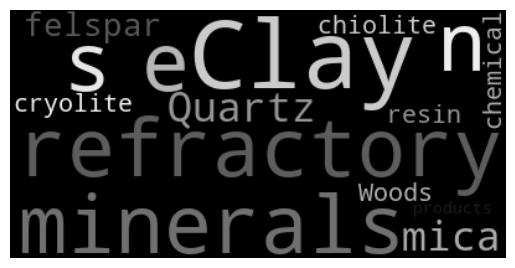

In [158]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[0]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

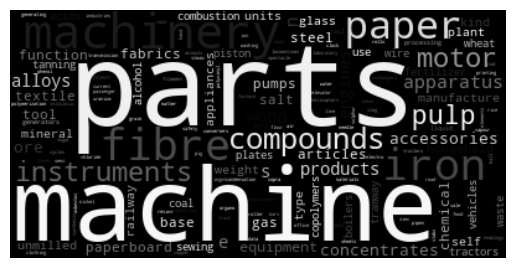

In [159]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[1]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

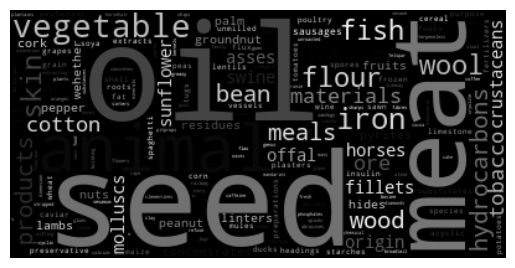

In [160]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[2]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

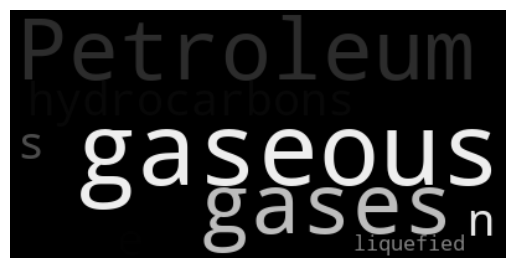

In [161]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[3]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

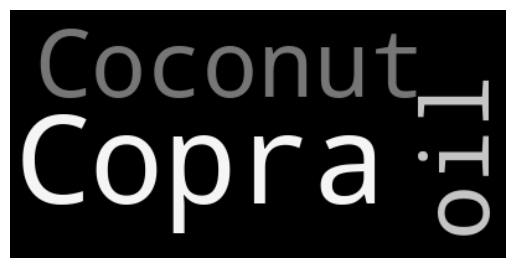

In [162]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[4]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

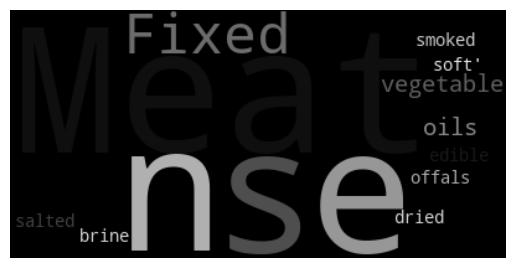

In [163]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[5]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

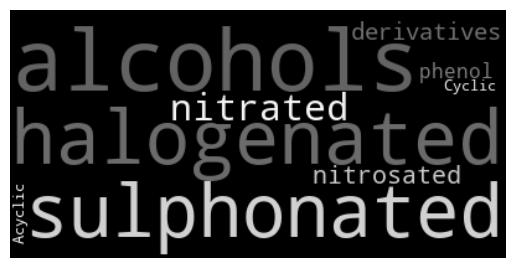

In [164]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[6]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

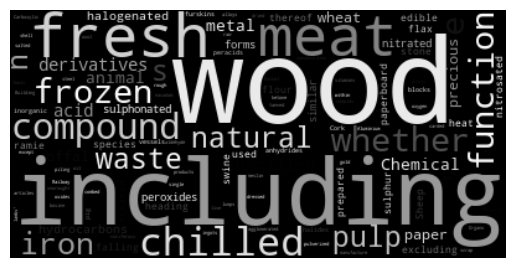

In [165]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[7]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

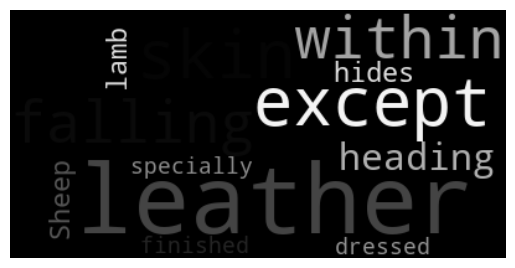

In [166]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[8]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

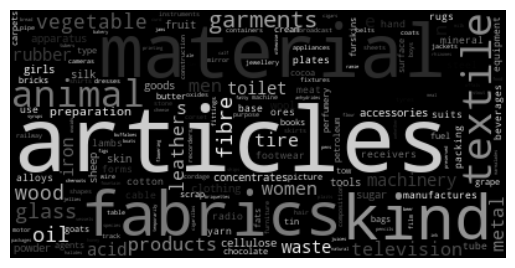

In [167]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[9]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [168]:
inv_partition[1]

['sugar products refining',
 'animals kind food',
 'animals zoo',
 'salt rock',
 'plates iron steel',
 'fish brine',
 'durum wheat, unmilled',
 'meal flour wheat',
 'barley, unmilled',
 'linseed',
 'wheat spelt',
 'rice husk',
 'rice',
 'stones strung',
 'oats, unmilled',
 'mineral tars products',
 'colloidal sulphur',
 'rye, unmilled',
 'cereal grains manner',
 'petroleum gases hydrocarbons',
 'other cellulosic pulps',
 'iron pigs',
 'paper paperboard scrap',
 'asbestos',
 'ores concentrates uranium',
 'flour meals flakes',
 'copra',
 'fruit peel',
 'chemical elements',
 'ketone function compounds',
 'sugars beet cane',
 '',
 'mineral chemical fertilizers',
 'pig poultry fat',
 'slag wool rock',
 'coconut (copra) oil',
 'wood packing cases',
 'wood pulp sulphite',
 'resins fusion run',
 'mechanical wood pulp',
 'nickel alloys',
 'sodium % weight',
 'newsprint',
 'wood pulp grades',
 'paper paperboard rolls',
 'radio materials',
 'casks barrels vats',
 'board wood pulp',
 'wood pulp so

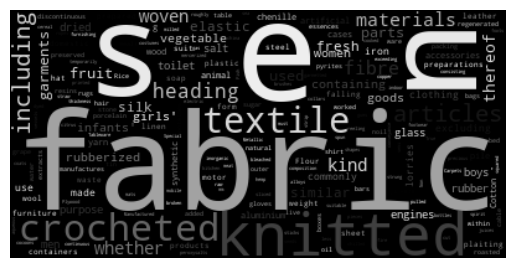

In [169]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[10]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

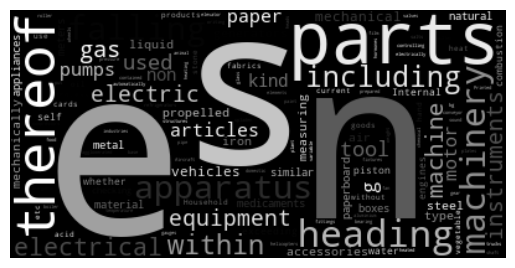

In [170]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[11]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

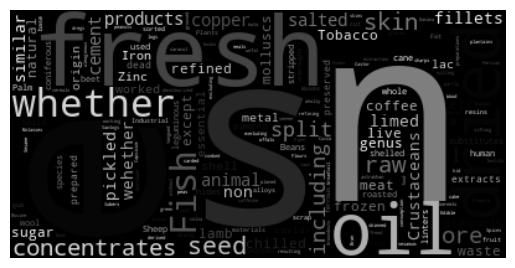

In [171]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[12]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

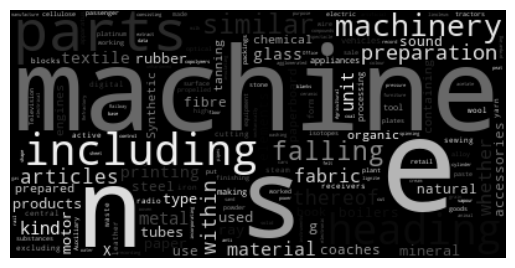

In [172]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[13]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

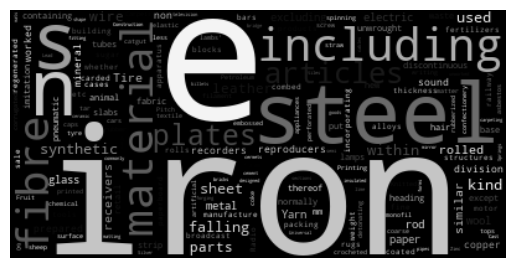

In [173]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[14]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()